Incorporating Social Network Data:


Graph-Based Features: Construct a graph where nodes are students and edges represent close relationships (e.g., mentioning each other). From this graph, you can derive features such as:


- Degree Centrality: How connected a student is within the network.
- Closeness Centrality: How quickly can a student reach other students in the network?
- Betweenness Centrality: How often a student lies on the shortest path between other   students, which might indicate a potential for being an opinion leader or gatekeeper.
- Eigenvector Centrality: A measure of the influence a student has in the network.
- Community Structure: Are there clusters or communities within the network that might   indicate shared beliefs or behaviors?

Aggregating Peer Features:


For each student, aggregate the features of their closest peers (e.g., average or median of peers’ opinions and activities) to use as additional predictors in your model.


In [1]:
import pandas as pd

demog_df = pd.read_csv(r"/Demographic_Features/data/binned_all_features.csv")

df = pd.read_csv(r"/dataset/netsense/netsurveysMergedWideCodedWithDates.csv")




In [24]:
!pip install -e C:\Users\MichalinaJanik\PycharmProjects\coding-fairness\shap_select


ERROR: C:\Users\MichalinaJanik\PycharmProjects\coding-fairness\shap_select is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [2]:
import pandas as pd
import re

try:

    def transform_column_name(col_name):
        return re.sub(r'_\d+$', '', col_name)

    variable_columns = [col for col in df.columns if re.search(r'_\d+$', col)]
    base_names = {col: transform_column_name(col) for col in variable_columns}
    constant_columns = [col for col in df.columns if col not in variable_columns]

    reshaped_data = []

    max_survey_num = max(int(re.search(r'_(\d+)$', col).group(1)) for col in variable_columns if re.search(r'_(\d+)$', col))
    for i in range(1, max_survey_num + 1):
        filtered_columns = [col for col in variable_columns if col.endswith(f'_{i}')]
        completed_col = f'Completed_{i}'

        if completed_col in df.columns:
            filtered_df = df[df[completed_col].notna()]

            if filtered_columns:
                temp_df = filtered_df[constant_columns].copy()
                temp_df.update(filtered_df[filtered_columns].rename(columns=base_names))
                temp_df['SurveyNr'] = i

                reshaped_data.append(temp_df)

    final_df = pd.concat(reshaped_data, ignore_index=True)

    print(final_df)

except Exception as e:
    print("Error:", e)

       EgoID  AlterID  SurveyNr
0      10060    85596         1
1      10060   103984         1
2      10060   106313         1
3      10060   119320         1
4      10060   120587         1
...      ...      ...       ...
13296  89827    66754         6
13297  89827   118098         6
13298  89827   154918         6
13299  89827   178233         6
13300  89827   192761         6

[13301 rows x 3 columns]


In [3]:
aggregated_df = final_df.groupby(['EgoID', 'SurveyNr']).agg(
    neighbours=('AlterID', lambda x: list(set(x))) ,neighbours_count=('AlterID', lambda x: len(set(x)))
).reset_index()

print(aggregated_df)

     EgoID  SurveyNr                                         neighbours  \
0    10060         1  [120587, 135565, 186641, 179607, 119320, 18665...   
1    10060         2  [138112, 136584, 51722, 186641, 119320, 181413...   
2    10060         3  [121792, 128068, 181413, 143462, 136584, 51722...   
3    10060         4  [120587, 135565, 186641, 179607, 119320, 18665...   
4    10060         5  [121792, 138112, 181413, 170919, 136584, 51722...   
..     ...       ...                                                ...   
968  96600         4  [116866, 166402, 167943, 124937, 103574, 10870...   
969  97942         1  [139264, 159375, 192273, 159252, 102423, 11254...   
970  97942         4  [139264, 159375, 192273, 159252, 102423, 11254...   
971  99338         1  [144773, 191625, 147980, 136346, 179234, 13994...   
972  99338         4  [144773, 191625, 147980, 136346, 179234, 13994...   

     neighbours_count  
0                  19  
1                  19  
2                  17  
3  

In [7]:
import pandas as pd
import networkx as nx

def build_graph_and_analyze(df):
    graph_metrics = {}
    for survey, group in df.groupby('SurveyNr'):
        G = nx.Graph()
        for _, row in group.iterrows():
            ego = row['EgoID']
            for neighbor in row['neighbours']:
                G.add_edge(ego, neighbor)

        # Calculate centrality measures
        graph_metrics[survey] = {
            'degree_centrality': nx.degree_centrality(G),
            'closeness_centrality': nx.closeness_centrality(G),
            'betweenness_centrality': nx.betweenness_centrality(G),
            'eigenvector_centrality': nx.eigenvector_centrality(G, max_iter=1000),
            'communities': nx.algorithms.community.greedy_modularity_communities(G)
        }
    return graph_metrics

results = build_graph_and_analyze(aggregated_df)

# Create a DataFrame for network metrics
network_data = []
for survey, metrics in results.items():
    for ego in metrics['degree_centrality'].keys():
        network_data.append({
            'EgoID': ego,
            'SurveyNr': survey,
            'Degree Centrality': metrics['degree_centrality'][ego],
            'Closeness Centrality': metrics['closeness_centrality'][ego],
            'Betweenness Centrality': metrics['betweenness_centrality'][ego],
            'Eigenvector Centrality': metrics['eigenvector_centrality'][ego],
            'Community': {node: idx for idx, community in enumerate(metrics['communities']) for node in community}.get(ego, -1)
        })

network_df = pd.DataFrame(network_data)

# Merge with demographic data




KeyError: 'EgoID'

Check the quality of results for the network features

Descriptive Statistics:
                egoid      SurveyNr  Degree Centrality  Closeness Centrality  \
count   13244.000000  13244.000000       13244.000000          13244.000000   
mean   142548.955301      3.086983           0.000910              0.025937   
std     39555.660706      1.643115           0.001787              0.032591   
min     10060.000000      1.000000           0.000307              0.000307   
25%    118996.000000      2.000000           0.000307              0.003150   
50%    146154.000000      3.000000           0.000436              0.005574   
75%    173551.000000      4.000000           0.000710              0.060680   
max    199995.000000      6.000000           0.017015              0.122735   

       Betweenness Centrality  Eigenvector Centrality     Community  
count            13244.000000            1.324400e+04  13244.000000  
mean                 0.000866            3.747943e-03     38.080263  
std                  0.005712            2.095284e-02

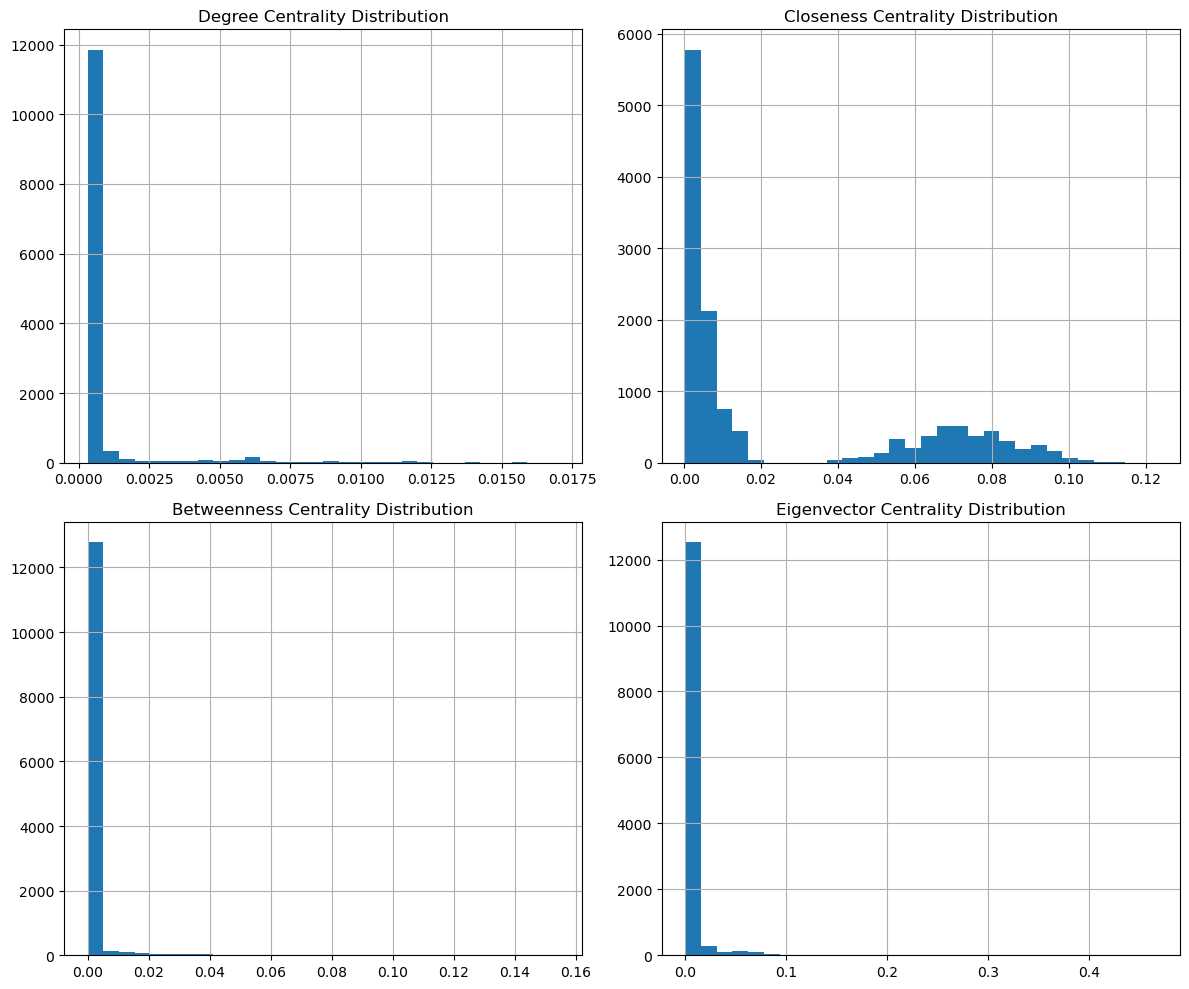

In [9]:
import pandas as pd
import matplotlib.pyplot as plt


descriptive_stats = network_df.describe()
print("Descriptive Statistics:\n", descriptive_stats)

# Check for zero variance
zero_variance = descriptive_stats.loc['std'] == 0
print("Columns with zero variance:\n", zero_variance[zero_variance == True])

# Visualize distributions of the centrality measures
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
network_df['Degree Centrality'].hist(ax=axes[0, 0], bins=30)
axes[0, 0].set_title('Degree Centrality Distribution')
network_df['Closeness Centrality'].hist(ax=axes[0, 1], bins=30)
axes[0, 1].set_title('Closeness Centrality Distribution')
network_df['Betweenness Centrality'].hist(ax=axes[1, 0], bins=30)
axes[1, 0].set_title('Betweenness Centrality Distribution')
network_df['Eigenvector Centrality'].hist(ax=axes[1, 1], bins=30)
axes[1, 1].set_title('Eigenvector Centrality Distribution')

plt.tight_layout()
plt.show()



In [19]:

if not zero_variance.any():
    # Merge with demographic data if quality checks are passed
    merged_df = pd.merge(demog_df, network_df, on=['egoid', 'SurveyNr'], how='left')
    print("Data merged successfully. Here's a preview:")
    print(merged_df.head())

    print(len(merged_df))
else:
    print("Detected zero variance in one or more columns. Review the network feature calculations.")





Data merged successfully. Here's a preview:
   egoid  SurveyNr  Discussed_Politics  Discussed_Religion  \
0  85596         2                  12                  17   
1  25323         2                  16                  26   
2  63188         2                  20                  26   
3  22931         2                  16                  17   
4  75261         2                  16                  26   

   Performed_Volunteer_Work  Felt_Depressed  timeperweekactivea  Drank_Beer  \
0                        12              12                   9           4   
1                         4              12                   8          12   
2                         8               4                   8           4   
3                         4               4                   8           4   
4                        12              12                   9          16   

   timeperweekactiveb  Exercised  ...  conscientiousness  neuroticism  health  \
0                  21      

In [20]:
merged_df = merged_df.dropna()

# Assuming 'network_df' is already created
missing_data = merged_df.isnull().sum() / len(merged_df) * 100
print("Percentage of missing data per column:\n", missing_data)

merged_df.to_csv(r'C:\Users\MichalinaJanik\PycharmProjects\coding-fairness\Demographic_Features\data\all_features_plus_neighbours.csv', index=False)

Percentage of missing data per column:
 egoid                       0.0
SurveyNr                    0.0
Discussed_Politics          0.0
Discussed_Religion          0.0
Performed_Volunteer_Work    0.0
                           ... 
Degree Centrality           0.0
Closeness Centrality        0.0
Betweenness Centrality      0.0
Eigenvector Centrality      0.0
Community                   0.0
Length: 66, dtype: float64


In [5]:
results

{1: {'graph': <networkx.classes.graph.Graph at 0x190c0cd7f80>,
  'degree_centrality': {10060: 0.005838967424708051,
   120587: 0.00030731407498463427,
   135565: 0.00030731407498463427,
   186641: 0.00030731407498463427,
   179607: 0.00030731407498463427,
   119320: 0.00030731407498463427,
   186651: 0.00030731407498463427,
   181413: 0.00030731407498463427,
   103984: 0.00030731407498463427,
   137524: 0.00030731407498463427,
   191422: 0.00030731407498463427,
   128068: 0.00030731407498463427,
   148932: 0.00030731407498463427,
   106313: 0.00030731407498463427,
   157899: 0.00030731407498463427,
   148045: 0.00030731407498463427,
   164439: 0.00030731407498463427,
   153179: 0.00030731407498463427,
   85596: 0.004917025199754148,
   143462: 0.00030731407498463427,
   10281: 0.00430239704978488,
   104610: 0.00030731407498463427,
   148675: 0.00030731407498463427,
   185123: 0.00030731407498463427,
   197765: 0.00030731407498463427,
   120230: 0.00030731407498463427,
   179723: 0.000